# Описание проекта


Из банка стали уходить клиенты каждый месяц. Из банка стали уходить клиенты каждый месяц. Спрогнозировать вероятность ухода клиента из банка в ближайшее время.

### Задачи проекта
Построить модель предсказания веротяности ухода, довести метрику `F1` до `0.59`.

### Описание данных

Данные находятся в файле `/datasets/Churn.csv`
Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Признаки:
* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — количество недвижимости у клиента
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата

Целевой признак
* `Exited` — факт ухода клиента


# Содержание <a name="title"></a>

[Импорт библиотек и задание констант](#import)
1. [Загрузка и анализ данных](#1)

 
2. [Подготовка данных](#2)


    
3. [Обучение моделей](#3)

    3.1 [Обучение модели линейной регрессии](#3.1)
    
    3.2 [Обучение модели CatBoostRegressor](#3.2)

    3.3 [Обучение модели LightGBM](#3.3)


4. [Тестирование](#4)

# Импорт библиотек и запись констант

In [1]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool

rng = 123 # используем константу в качестве random_state

# 1 Подготовка данных

Откроем файл с данными и изучим информацию.

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Приведем столбцы к нижнему регистру для удобства дальнейшей работы. Проверим результат.

In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
rownumber          10000 non-null int64
customerid         10000 non-null int64
surname            10000 non-null object
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             9091 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В столбце **tenure** наблюдаются пропуски. Перед началом анализа необходимо заполнить пропуски.

Просмотрим отсутствующие значения.

In [6]:
# проверочный датасет, для проверки заполнения
check_df = df[pd.isnull(df['tenure'])]
check_df.head(10)

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


Закономерности не отслеживаются.

Перед началом заполнения удалим столбцы, которые могут повлиять на результат обучения, но несут полезной нагрузки.

In [7]:
df.drop(columns=['rownumber', 'customerid', 'surname'], inplace=True)

In [8]:
df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Преобразуем категориальные признаки в численные при помощи техники прямого кодирования, или отображения (**One-Hot Encoding, OHE**), предусмотрев наличие дамми ловушек (dummy trap).

In [9]:
df_new = pd.get_dummies(df, drop_first=True)
df_new.columns = df_new.columns.str.lower()

In [10]:
df_new.head(5)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_germany,geography_spain,gender_male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Для заполнения пропусков воспользуемся **Iterative.Imputer** из библиотеки **sklearn.impute**.

**Iterative.Imputer** заполняет отсутствующие значения путём оценки остальных признаков.

In [11]:
# задаём модель с ограниченными рамками и обучаем её
imp = IterativeImputer(max_iter=10, random_state=rng, sample_posterior=True, min_value=0, max_value=10)
imp.fit(df_new)
IterativeImputer(random_state=rng)
# получаем готовый датасет 
good_df = pd.DataFrame(imp.transform(df_new))
good_df.columns = df_new.columns
good_df['tenure'] = np.round(good_df['tenure'])

Проверим заполнение по заранее сохранённому датасету.

In [12]:
good_df.query('index in @check_df.index').head(10)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_germany,geography_spain,gender_male
30,591.0,39.0,3.0,0.00,3.0,1.0,0.0,140469.38,1.0,0.0,1.0,0.0
48,550.0,38.0,6.0,103391.38,1.0,0.0,1.0,90878.13,0.0,1.0,0.0,1.0
51,585.0,36.0,2.0,146050.97,2.0,0.0,0.0,86424.57,0.0,1.0,0.0,1.0
53,655.0,41.0,7.0,125561.97,1.0,0.0,0.0,164040.94,1.0,1.0,0.0,1.0
60,742.0,35.0,6.0,136857.00,1.0,0.0,0.0,84509.57,0.0,1.0,0.0,1.0
82,543.0,36.0,9.0,0.00,2.0,0.0,0.0,26019.59,0.0,0.0,0.0,0.0
85,652.0,75.0,6.0,0.00,2.0,1.0,1.0,114675.75,0.0,0.0,1.0,0.0
94,730.0,42.0,7.0,0.00,2.0,0.0,1.0,85982.47,0.0,0.0,1.0,1.0
99,413.0,34.0,1.0,0.00,2.0,0.0,0.0,6534.18,0.0,0.0,0.0,1.0
111,538.0,39.0,5.0,108055.10,2.0,1.0,0.0,27231.26,0.0,1.0,0.0,1.0


Также проверим сумму всех возможных значений.

In [13]:
df1 = pd.DataFrame(df_new['tenure'].value_counts())
df2 = pd.DataFrame(good_df['tenure'].value_counts())
pd.merge(df1, df2, left_index=True, right_index=True)

,tenure_x,tenure_y
1.0,952,1009
2.0,950,1040
8.0,933,1008
3.0,928,1040
5.0,927,1046
7.0,925,1024
4.0,885,1026
9.0,882,931
6.0,881,1012
10.0,446,461


Данные распределились равномерно, это значит, что они не должны испортить результат анализа.

Произведем масштабирование признаков методом стандартизации данных, чтобы избежать ошибок в алгоритме. Для этого воспользуемся методом **StandardScaler** из библиотеки **sklearn.preprocessing**.

In [14]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

scaler = StandardScaler()
scaler.fit(good_df[numeric])

good_df[numeric] = scaler.transform(good_df[numeric])
good_df.head(5)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_germany,geography_spain,gender_male
0,-0.326221,0.293517,-1.045987,-1.225848,-0.911583,1.0,1.0,0.021886,1.0,0.0,0.0,0.0
1,-0.440036,0.198164,-1.396566,0.117350,-0.911583,0.0,1.0,0.216534,0.0,0.0,1.0,0.0
2,-1.536794,0.293517,1.057486,1.333053,2.527057,1.0,0.0,0.240687,1.0,0.0,0.0,0.0
3,0.501521,0.007457,-1.396566,-1.225848,0.807737,0.0,0.0,-0.108918,0.0,0.0,0.0,0.0
4,2.063884,0.388871,-1.045987,0.785728,-0.911583,1.0,1.0,-0.365276,0.0,0.0,1.0,0.0


Данные готовы для проведения исследования.

# 2 Исследование задачи

## 2.1 Исследование баланса классов

Исследуем баланс классов в исходной выборке.

0.0    0.7963
1.0    0.2037
Name: exited, dtype: float64


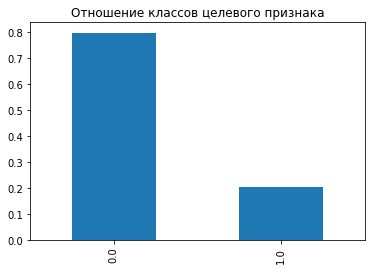

In [15]:
class_frequency = good_df['exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title("Отношение классов целевого признака")
plt.show()

Согласно полученным данным, ушедших клиентов на четверть меньше. Это значит, что обученная модель должна быть точнее 79% константной модели для подтверждения адекватности. 

## 2.2 Разделение выборки

Произведем разделение данных на обучающую, валидационную и тестовую выборку.

In [16]:
target = good_df['exited']
features = good_df.drop('exited', axis=1)

features_train_valid, features_test, target_train_valid, target_test = train_test_split(features, target, test_size=0.2, random_state=rng)

features_train, features_valid, target_train, target_valid = train_test_split(features_train_valid, target_train_valid, test_size=0.25, random_state=rng)

## 2.3 Обучение модели с дисбалансом классов

### 2.3.1 Обучение моделей решающего древа с дисбалансом классов

В качестве оценки моделей воспользуемся точностью и f1 мерой.

In [17]:
data = {'max_depth': [], 'accuracy': [], 'f1': []}
research = pd.DataFrame(data=data)
research.head()
i = 0
for depth in range(2, 15, 1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=rng)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    research.loc[i] = (depth, accuracy, f1)
    i += 1

In [18]:
research.head(15)

,max_depth,accuracy,f1
0,2.0,0.8225,0.492132
1,3.0,0.8350,0.402174
2,4.0,0.8415,0.438938
3,5.0,0.8500,0.567723
4,6.0,0.8440,0.517028
5,7.0,0.8475,0.534351
6,8.0,0.8495,0.541857
7,9.0,0.8395,0.532751
8,10.0,0.8280,0.530055
9,11.0,0.8165,0.520261


Наилучшие показатели показывает модель решающего древа с глубиной древа 5.

### 2.3.2 Обучение моделей случайного леса с дисбалансом классов

In [19]:
data = {'n_estimators': [], 'accuracy': [], 'f1': []}
research = pd.DataFrame(data=data)
research.head()
i = 0
for estim in range(1, 55, 2):
    model = RandomForestClassifier(n_estimators=estim, random_state=rng)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    research.loc[i] = (estim, accuracy, f1)
    i += 1

In [20]:
research.head(25)

,n_estimators,accuracy,f1
0,1.0,0.7745,0.453333
1,3.0,0.8235,0.519728
2,5.0,0.8335,0.524964
3,7.0,0.8425,0.540146
4,9.0,0.8410,0.536443
5,11.0,0.8455,0.544919
6,13.0,0.8480,0.548961
7,15.0,0.8495,0.551416
8,17.0,0.8520,0.559524
9,19.0,0.8530,0.558559


Наилучшие показатели показывает модель случайного леса с количеством решающих деревьев равым 39.

### 2.3.3 Обучение логистической регрессии с дисбалансом классов

In [21]:
model = LogisticRegression(random_state=rng, solver='lbfgs')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
print(f'Модель логистической регрессии обученная на сокращённой выборка выдаёт {accuracy} доли правильных ответов со значением f1 меры равным {f1}.')

Модель логистической регрессии обученная на сокращённой выборка выдаёт 0.8035 доли правильных ответов со значением f1 меры равным 0.2788990825688073.


Модель выдает низкое качество f1 меры и точность близкую к константной модели.

## 2.4 Вывод

Наилучшие показатели для данной задачи показывает модель случайного леса с количеством деревьем равным 39. Полученная модель показывает точность 86,7% и F1 меру равную 0,567, что ниже установленного в задании порога.

Наихудшие показатели обеспечивает модель логистической регрессии. Она плохо подходит для решения поставленной задачи.

Для повышения показателей будем улучшать выбранную модель случайного леса.

# 3. Борьба с дисбалансом

Обучим модель случайного леса с количеством деревьев равным 39, применив несколько вариантов борьбы с дисбалансом. Также добавим к оценке значение площади под кривой оценки (**auc_roc**).

In [22]:
data = {'balance': [], 'n_estimators': [], 'accuracy': [], 'f1': [], 'auc_roc': []}
research = pd.DataFrame(data=data)

model = RandomForestClassifier(n_estimators=39, random_state=rng)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
research.loc[0] = ('without balance', 39, accuracy, f1, auc_roc)

model = RandomForestClassifier(n_estimators=39, random_state=rng, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
research.loc[1] = ('with balance', 39, accuracy, f1, auc_roc)

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)   
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

model = RandomForestClassifier(n_estimators=39, random_state=rng)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
research.loc[2] = ('with upsampling', 39, accuracy, f1, auc_roc)

model = RandomForestClassifier(n_estimators=39, random_state=rng, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
research.loc[3] = ('with balance upsampling', 39, accuracy, f1, auc_roc)

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

model = RandomForestClassifier(n_estimators=39, random_state=rng)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
research.loc[4] = ('with downsampling', 39, accuracy, f1, auc_roc)

model = RandomForestClassifier(n_estimators=39, random_state=rng, class_weight='balanced')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
research.loc[5] = ('with balance downsampling', 39, accuracy, f1, auc_roc)

research

,balance,n_estimators,accuracy,f1,auc_roc
0,without balance,39.0,0.8570,0.567976,0.821970
1,with balance,39.0,0.8565,0.567119,0.832181
2,with upsampling,39.0,0.8430,0.575676,0.820357
3,with balance upsampling,39.0,0.8450,0.588859,0.827233
4,with downsampling,39.0,0.7640,0.554717,0.819840
5,with balance downsampling,39.0,0.7585,0.544769,0.819691


Наилучщий показатель **f1** показывает модель с использованием увеличенной выборки с применением взвешивания классов. Выбранный алгоритм позволил увеличить показатель **f1**, однако незначительно снизил долю правильных ответов. Используем данную модель для тестирования с учетом расширенной выборки.

# 4. Тестирование модели

Выбранную модель случайного леса дообучим на расширенной выборке, для повышения показателей.

In [23]:
data = {'balance': [], 'n_estimators': [], 'accuracy': [], 'f1': [], 'auc_roc': []}
result = pd.DataFrame(data=data)

features_upsampled, target_upsampled = upsample(features_train_valid, target_train_valid, 4)

model = RandomForestClassifier(n_estimators=39, random_state=rng, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
accuracy = accuracy_score(target_test, predicted_test)
f1 = f1_score(target_test, predicted_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
result.loc[0] = ('with balance upsampling', 39, accuracy, f1, auc_roc)

target_pred_constant = pd.Series(0, target.index)

result

,balance,n_estimators,accuracy,f1,auc_roc
0,with balance upsampling,39.0,0.849,0.600529,0.84469


После дообучения все показатели были увеличены, полученная модель соответствует предъявляемым требованиям.

Также исследуем модель обученную на основе **CatBoost**.

In [24]:
data = {'model': [], 'accuracy': [], 'f1': [], 'auc_roc': []}
result = pd.DataFrame(data=data)

model = CatBoostClassifier(random_state=rng)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
accuracy = accuracy_score(target_test, predicted_test)
f1 = f1_score(target_test, predicted_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
result.loc[0] = ('CatBoost', accuracy, f1, auc_roc)

Learning rate set to 0.034524
0:	learn: 0.6745788	total: 155ms	remaining: 2m 34s
1:	learn: 0.6578965	total: 260ms	remaining: 2m 9s
2:	learn: 0.6431334	total: 365ms	remaining: 2m 1s
3:	learn: 0.6288619	total: 553ms	remaining: 2m 17s
4:	learn: 0.6157512	total: 655ms	remaining: 2m 10s
5:	learn: 0.6043025	total: 757ms	remaining: 2m 5s
6:	learn: 0.5938003	total: 858ms	remaining: 2m 1s
7:	learn: 0.5835581	total: 961ms	remaining: 1m 59s
8:	learn: 0.5746055	total: 1.15s	remaining: 2m 6s
9:	learn: 0.5664423	total: 1.25s	remaining: 2m 3s
10:	learn: 0.5594165	total: 1.35s	remaining: 2m 1s
11:	learn: 0.5534915	total: 1.54s	remaining: 2m 7s
12:	learn: 0.5481854	total: 1.65s	remaining: 2m 4s
13:	learn: 0.5418686	total: 1.75s	remaining: 2m 3s
14:	learn: 0.5365232	total: 1.85s	remaining: 2m 1s
15:	learn: 0.5314126	total: 2.05s	remaining: 2m 5s
16:	learn: 0.5268443	total: 2.15s	remaining: 2m 4s
17:	learn: 0.5231180	total: 2.34s	remaining: 2m 7s
18:	learn: 0.5197830	total: 2.45s	remaining: 2m 6s
19:	lea

158:	learn: 0.4132173	total: 20.7s	remaining: 1m 49s
159:	learn: 0.4128162	total: 20.8s	remaining: 1m 49s
160:	learn: 0.4123878	total: 21s	remaining: 1m 49s
161:	learn: 0.4122053	total: 21.1s	remaining: 1m 49s
162:	learn: 0.4119255	total: 21.2s	remaining: 1m 48s
163:	learn: 0.4115358	total: 21.4s	remaining: 1m 48s
164:	learn: 0.4113156	total: 21.5s	remaining: 1m 48s
165:	learn: 0.4110086	total: 21.7s	remaining: 1m 48s
166:	learn: 0.4106601	total: 21.8s	remaining: 1m 48s
167:	learn: 0.4103806	total: 21.9s	remaining: 1m 48s
168:	learn: 0.4101326	total: 22s	remaining: 1m 48s
169:	learn: 0.4099304	total: 22.2s	remaining: 1m 48s
170:	learn: 0.4096373	total: 22.3s	remaining: 1m 47s
171:	learn: 0.4094363	total: 22.4s	remaining: 1m 47s
172:	learn: 0.4091485	total: 22.5s	remaining: 1m 47s
173:	learn: 0.4088463	total: 22.6s	remaining: 1m 47s
174:	learn: 0.4083630	total: 22.8s	remaining: 1m 47s
175:	learn: 0.4081722	total: 22.9s	remaining: 1m 47s
176:	learn: 0.4079633	total: 23.1s	remaining: 1m 4

315:	learn: 0.3711003	total: 40.6s	remaining: 1m 27s
316:	learn: 0.3708267	total: 40.8s	remaining: 1m 27s
317:	learn: 0.3705666	total: 40.9s	remaining: 1m 27s
318:	learn: 0.3703563	total: 41s	remaining: 1m 27s
319:	learn: 0.3701928	total: 41.1s	remaining: 1m 27s
320:	learn: 0.3699834	total: 41.2s	remaining: 1m 27s
321:	learn: 0.3697334	total: 41.3s	remaining: 1m 27s
322:	learn: 0.3695110	total: 41.4s	remaining: 1m 26s
323:	learn: 0.3692744	total: 41.5s	remaining: 1m 26s
324:	learn: 0.3689695	total: 41.7s	remaining: 1m 26s
325:	learn: 0.3686851	total: 41.8s	remaining: 1m 26s
326:	learn: 0.3684410	total: 41.9s	remaining: 1m 26s
327:	learn: 0.3680992	total: 42s	remaining: 1m 26s
328:	learn: 0.3678407	total: 42.2s	remaining: 1m 26s
329:	learn: 0.3675437	total: 42.3s	remaining: 1m 25s
330:	learn: 0.3673320	total: 42.4s	remaining: 1m 25s
331:	learn: 0.3671359	total: 42.6s	remaining: 1m 25s
332:	learn: 0.3669232	total: 42.7s	remaining: 1m 25s
333:	learn: 0.3667509	total: 42.8s	remaining: 1m 2

471:	learn: 0.3365937	total: 1m	remaining: 1m 7s
472:	learn: 0.3363388	total: 1m	remaining: 1m 7s
473:	learn: 0.3361510	total: 1m	remaining: 1m 7s
474:	learn: 0.3358977	total: 1m 1s	remaining: 1m 7s
475:	learn: 0.3356547	total: 1m 1s	remaining: 1m 7s
476:	learn: 0.3355365	total: 1m 1s	remaining: 1m 7s
477:	learn: 0.3352982	total: 1m 1s	remaining: 1m 7s
478:	learn: 0.3350854	total: 1m 1s	remaining: 1m 6s
479:	learn: 0.3347821	total: 1m 1s	remaining: 1m 6s
480:	learn: 0.3345560	total: 1m 1s	remaining: 1m 6s
481:	learn: 0.3342696	total: 1m 1s	remaining: 1m 6s
482:	learn: 0.3340960	total: 1m 2s	remaining: 1m 6s
483:	learn: 0.3339063	total: 1m 2s	remaining: 1m 6s
484:	learn: 0.3337524	total: 1m 2s	remaining: 1m 6s
485:	learn: 0.3335421	total: 1m 2s	remaining: 1m 5s
486:	learn: 0.3333108	total: 1m 2s	remaining: 1m 5s
487:	learn: 0.3331615	total: 1m 2s	remaining: 1m 5s
488:	learn: 0.3328945	total: 1m 2s	remaining: 1m 5s
489:	learn: 0.3325334	total: 1m 2s	remaining: 1m 5s
490:	learn: 0.3322434

628:	learn: 0.3065870	total: 1m 20s	remaining: 47.7s
629:	learn: 0.3064568	total: 1m 20s	remaining: 47.5s
630:	learn: 0.3062966	total: 1m 21s	remaining: 47.4s
631:	learn: 0.3060963	total: 1m 21s	remaining: 47.3s
632:	learn: 0.3059480	total: 1m 21s	remaining: 47.1s
633:	learn: 0.3057362	total: 1m 21s	remaining: 47s
634:	learn: 0.3055346	total: 1m 21s	remaining: 46.9s
635:	learn: 0.3053055	total: 1m 21s	remaining: 46.8s
636:	learn: 0.3052002	total: 1m 21s	remaining: 46.7s
637:	learn: 0.3050825	total: 1m 22s	remaining: 46.5s
638:	learn: 0.3049273	total: 1m 22s	remaining: 46.4s
639:	learn: 0.3047629	total: 1m 22s	remaining: 46.2s
640:	learn: 0.3045563	total: 1m 22s	remaining: 46.2s
641:	learn: 0.3043502	total: 1m 22s	remaining: 46s
642:	learn: 0.3040478	total: 1m 22s	remaining: 45.9s
643:	learn: 0.3038468	total: 1m 22s	remaining: 45.8s
644:	learn: 0.3037256	total: 1m 22s	remaining: 45.6s
645:	learn: 0.3035165	total: 1m 23s	remaining: 45.5s
646:	learn: 0.3032947	total: 1m 23s	remaining: 45.

784:	learn: 0.2807725	total: 1m 40s	remaining: 27.6s
785:	learn: 0.2805875	total: 1m 40s	remaining: 27.5s
786:	learn: 0.2804855	total: 1m 41s	remaining: 27.4s
787:	learn: 0.2804061	total: 1m 41s	remaining: 27.2s
788:	learn: 0.2801796	total: 1m 41s	remaining: 27.1s
789:	learn: 0.2800597	total: 1m 41s	remaining: 27s
790:	learn: 0.2799587	total: 1m 41s	remaining: 26.8s
791:	learn: 0.2798603	total: 1m 41s	remaining: 26.7s
792:	learn: 0.2796726	total: 1m 41s	remaining: 26.6s
793:	learn: 0.2795553	total: 1m 41s	remaining: 26.5s
794:	learn: 0.2794552	total: 1m 42s	remaining: 26.3s
795:	learn: 0.2792776	total: 1m 42s	remaining: 26.2s
796:	learn: 0.2791370	total: 1m 42s	remaining: 26.1s
797:	learn: 0.2789794	total: 1m 42s	remaining: 25.9s
798:	learn: 0.2788597	total: 1m 42s	remaining: 25.8s
799:	learn: 0.2786210	total: 1m 42s	remaining: 25.7s
800:	learn: 0.2784648	total: 1m 42s	remaining: 25.6s
801:	learn: 0.2782505	total: 1m 42s	remaining: 25.4s
802:	learn: 0.2780520	total: 1m 43s	remaining: 2

940:	learn: 0.2588733	total: 2m 1s	remaining: 7.61s
941:	learn: 0.2587342	total: 2m 1s	remaining: 7.47s
942:	learn: 0.2586193	total: 2m 1s	remaining: 7.34s
943:	learn: 0.2585152	total: 2m 1s	remaining: 7.22s
944:	learn: 0.2584200	total: 2m 1s	remaining: 7.09s
945:	learn: 0.2582811	total: 2m 1s	remaining: 6.96s
946:	learn: 0.2581126	total: 2m 2s	remaining: 6.83s
947:	learn: 0.2579841	total: 2m 2s	remaining: 6.7s
948:	learn: 0.2578205	total: 2m 2s	remaining: 6.57s
949:	learn: 0.2577017	total: 2m 2s	remaining: 6.44s
950:	learn: 0.2576150	total: 2m 2s	remaining: 6.31s
951:	learn: 0.2573963	total: 2m 2s	remaining: 6.18s
952:	learn: 0.2572741	total: 2m 2s	remaining: 6.05s
953:	learn: 0.2571105	total: 2m 2s	remaining: 5.92s
954:	learn: 0.2570281	total: 2m 2s	remaining: 5.79s
955:	learn: 0.2568952	total: 2m 3s	remaining: 5.67s
956:	learn: 0.2567988	total: 2m 3s	remaining: 5.54s
957:	learn: 0.2566745	total: 2m 3s	remaining: 5.41s
958:	learn: 0.2565387	total: 2m 3s	remaining: 5.28s
959:	learn: 0

In [25]:
result

,model,accuracy,f1,auc_roc
0,CatBoost,0.828,0.625272,0.872474


Модель обученная на основе **catboost** показывает высокое значение f1 меры, однако пониженную долю правильных ответов. Для работы рекомендуется применять модель случайного леса с количеством решающих деревьев равным 39, модель должна быть обучена на расширенной выборке с учетом дисбаланса классов.